In [1]:
# Imports
from IPython.display import HTML
import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

winnie.utils.setup_jupyter_display()

In [2]:
# Prep the SpaceRDI object:
distance = 9.714 # Distance to your target in parsecs

base_dir = './aumic_rdi_example/'
input_dir = f'{base_dir}coadded/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

The core RDI procedure used by Winnie constructs a stellar PSF model in two major steps.

1) Calculate reference image coefficients

2) Construct the stellar PSF model using those coefficients

Throughout all of the included RDI variants, step 2 remains unchanged. Irrespective of the flavor of RDI, we **always** construct the stellar PSF model image, $\mathcal{M}$, for each science image as:

$
\begin{align}
\mathcal{M} = \{ c_0 R_0 + c_1 R_1 + c_2 R_2 + ... \}= \sum_i c_i R_i
\end{align}
$

where $c_i$ is the coefficient for i$\rm^{th}$ reference image, $R_i$. In simpler terms: we make our PSF model image by multiplying each reference image by a constant and then adding the results together.

What differs between the RDI variants is how the optimal coefficients (the constants) are computed. 

**wdb.rdi_presets()**: Standard RDI; coefficients give the linear combination of <font color='red'>**reference images**</font> that minimizes squared residuals with the <font color='blue'>**science image**</font>

**wdb.mcrdi_presets()**: Model Constrained RDI (MCRDI); coefficients give the linear combination of <font color='red'>**reference images**</font> that minimizes squared residuals with the <font color='blue'>**disk-model-subtracted science image**</font>

**wdb.hpfdi_presets()**: High-Pass Filtered RDI (HPFRDI); coefficients give the linear combination of <font color='red'>**high-pass-filtered reference images**</font> that minimizes squared residuals with the <font color='blue'>**high-pass-filtered science image**</font>

All three presets methods are purely for convenience. Under the hood, all of these methods are passing RDI settings to the set_rdi_presets method, which populates the wdb.rdi_settings dictionary and sets the output extension for saving files. 

Ultimately, for any RDI process, we'll use the run_rdi method. 

In run_rdi, we do some JWST-specific book-keeping and formatting before calling the more generalized winnie.rdi.rdi_residuals function. rdi_residuals has a lot of options you might find useful. A section of the docstring is included below (sans anything that is already set by run_rdi).

**Note: The winnie.rdi code was written for ground-based IFS/IFU data, so operates on 4D data sequences (N exposures $\times$ N wavelengths $\times$ ny $\times$ nx). These are referred to as "hcubes" (hypercubes) in the winnie.rdi documentation. hcube is the science target sequence and hcube_ref is the reference target sequence. For our use, we simply add a length 1 axis to our 3D JWST data sequences; e.g.,** ```hcube = imcube[:, np.newaxis]```

    hcube_css: ndarray
        4D array; same shape as hcube. hcube_css should provide an estimate of the circumstellar signal 
        in hcube, rotated to the appropriate posangs and convolved with the appropriate PSF.

    ref_mask: ndarray
        2D boolean array of shape (len(optzones), nT_ref) that indicates which reference images should be considered
        for which optimization regions. E.g., if ref_mask[i,j] is False, then for the ith optimization zone (optzones[i]),
        the jth reference image (hcube_ref[j]) will NOT be used for construction of the PSF model. This can be useful if
        some reference exposures have anomalous features that make them problematic for some regions while still being
        suitable for others; e.g., an image with a bright background source near the edge of the FOV may still be useful
        for nulling the PSF near the inner working angle.

    objective: bool
        If True, the output array will be (hcube - hcube_css) - hcube_psfmodel, where hcube_psfmodel is 
        constructed by comparing hcube_ref to (hcube - hcube_css). If False, the output array will simply
        be hcube - hcube_psfmodel. If hcube_css is None, then setting this will have no effect. 

    zero_nans: bool
        If True, any nans in the optimization zones will be replaced with zeros for the procedure.

    return_psf_model: bool
        If True, the PSF-model hcube matching hcube in shape is returned instead of the residuals hcube. Will not be
        derotated (even if posangs is specified).

    return_coeffs: bool
        If True, returns only the array of PSF model coefficients.

    coeffs_in: ndarray
        If provided, these coefficients will be used to construct the PSF model instead of computing coefficients.

    opt_smoothing_fn: callable or None
        If not None, this argument indicates the function with which to smooth the sequences. This should
        be a function that takes a hypercube along with some keyword arguments and returns a smoothed hypercube, 
        i.e.: hcube_filt = opt_smoothing_fn(hcube, **opt_smoothing_kwargs).
        
    opt_smoothing_kwargs: dict
        If opt_smoothing_fn is not None, arguments to pass to opt_smoothing_fn when it is called.
        
Values for these keywords can be set in three ways:

1) Using presets (rdi_presets, hpfrdi_presets, mcrdi_presets, or the generic set_presets methods)

    - rdi_presets simply clears the current settings to get a "standard" RDI reduction
    
    - mcrdi_presets adds hcube_css to the current config
    
    - hpfrdi_presets adds opt_smoothing_fn and opt_smoothing_kwargs
    
 
2) Using the set_fixed_rdi_settings method
    - these settings will remain when changing presets
    

3) Using the extra_rdi_settings keyword argument for the run_rdi method
    - these settings will be used only for this execution of run_rdi
    

You can alter the rdi_settings dictionary manually as well. However, this will override the typical behavior of any fixed RDI settings. If fully custom settings are needed, the set_presets method is the preferred way to set them.

**Note: When loading a new concatenation, all RDI settings are erased! This includes any custom optimization / subtraction zones.**

**"Why use the presets or set_fixed_rdi_settings methods instead of just passing the desired settings in with the extra_rdi_settings argument?"**

Mostly forward modeling. If your settings are saved to the object, you can run your RDI reduction with wdb.run_rdi() and then later apply forward modeling for the same settings simply by executing wdb.run_rdi(forward_model=True) after setting a model with the set_circumstellar_model method. 

**"How is priority determined between the three?"**

Any settings assigned with the set_fixed_rdi_settings method will overwrite duplicate settings in the presets methods. If you duplicate a setting controlled by either of these in extra_rdi_settings, run_rdi will crash with a keyword argument repeated SyntaxError.

### Some examples showing how you might use set_fixed_rdi_settings and extra_rdi_settings

**fixed_rdi_settings**:

Say we've noticed after an initial RDI reduction that one of our reference images in the current concatenation has a significant artifact that's negatively impacting our reductions. 

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x154daf740>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


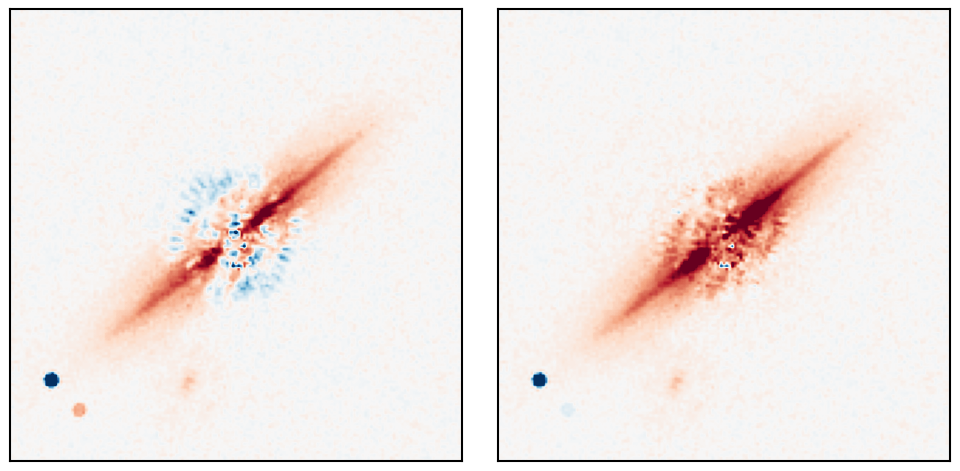

In [3]:
# Adding a fake artifact to one of the reference images and running RDI
wdb.load_concat(0)

fake_artifact = np.where(winnie.utils.dist_to_pt([123,248], wdb.nx, wdb.ny) < 2.5, 5.0, 0.0)
bad_ind = 3
wdb.imcube_ref[bad_ind] += fake_artifact

wdb.rdi_presets()
rdi_artifact = wdb.run_rdi()

wdb.hpfrdi_presets()
hpfrdi_artifact = wdb.run_rdi()

quick_implot([rdi_artifact.im, hpfrdi_artifact.im], cmap='RdBu_r', clim_perc=99.9, extent=rdi_artifact.extent, lims=[-5,5])

Let's use "ref_mask" (see doctstring above) to explicitly exclude the offending image from our RDI procedure

In [4]:
# Build an initial "ref_mask", which is a boolean array of shape (Nzones, Nrefs)
ref_mask = np.ones((wdb.optzones.shape[0], wdb.imcube_ref.shape[0]), dtype='bool')

# then set the entry for our image containing the artifact to False
ref_mask[:,bad_ind] = False

# Add ref_mask as a fixed RDI setting
wdb.set_fixed_rdi_settings(ref_mask=ref_mask)

# Rerun both RDI procedures
wdb.rdi_presets()
rdi_noartifact = wdb.run_rdi()

wdb.hpfrdi_presets()
hpfrdi_noartifact = wdb.run_rdi()

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
'ref_mask': <class 'numpy.ndarray'> of shape (1, 6)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x154daf740>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
'ref_mask': <class 'numpy.ndarray'> of shape (1, 6)
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


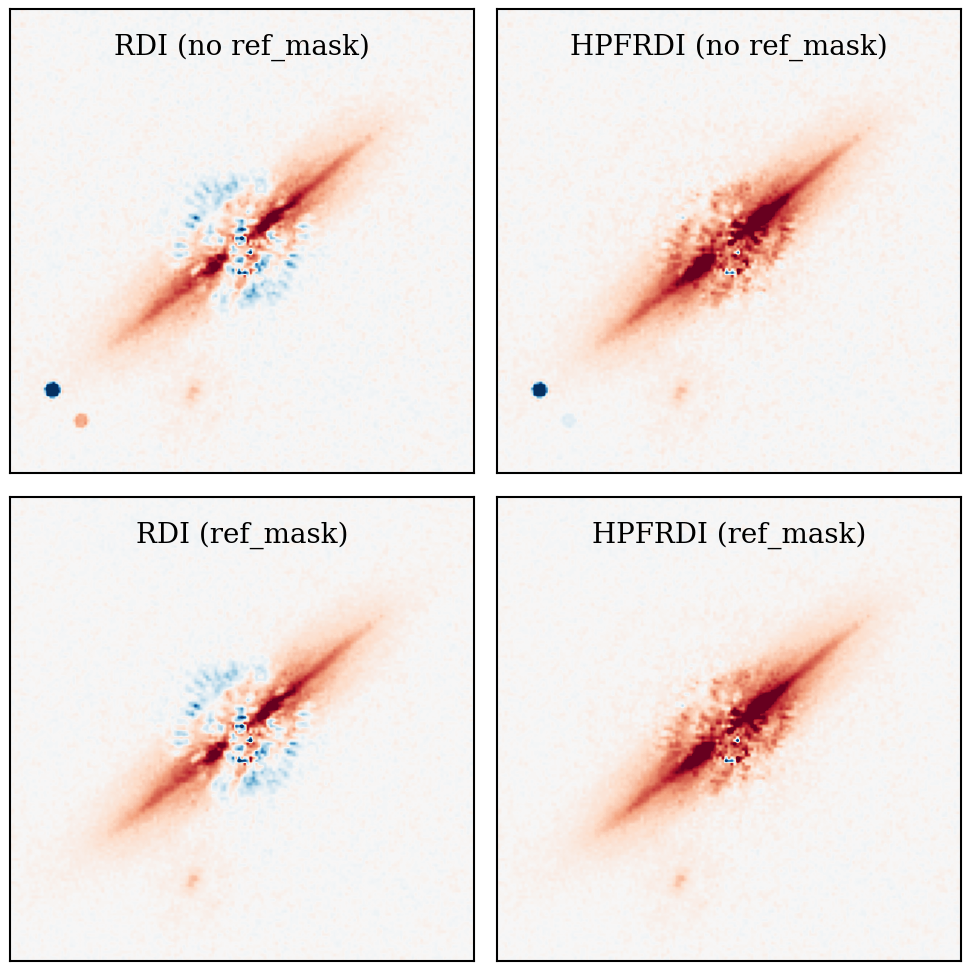

In [5]:
fig,axes = quick_implot([[rdi_artifact.im, hpfrdi_artifact.im],
              [rdi_noartifact.im, hpfrdi_noartifact.im]], cmap='RdBu_r', clim_perc=99.9, extent=rdi_artifact.extent, lims=[-5,5], show=False)

labels = ['RDI (no ref_mask)', 'HPFRDI (no ref_mask)', 'RDI (ref_mask)', 'HPFRDI (ref_mask)']

for i,ax in enumerate(axes):
    ax.text(0.5, 0.95, labels[i], ha='center', va='top', transform=ax.transAxes, fontsize=20)

In this case, we could also have simply excluded the offending reference image from our database / directory. The more unique utility of ref_mask is the ability to exclude reference images for individual optimization zones. E.g., we could break our PSF subtraction into inner and outer optimization zones, and then exclude the image with the artifact for only the outer zone, potentially improving the PSF model for the inner zone without being forced to accept the artifact in our result. 

**extra_rdi_settings**:

Let's reset and take a closer look at the two rolls for a standard RDI reduction. 

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


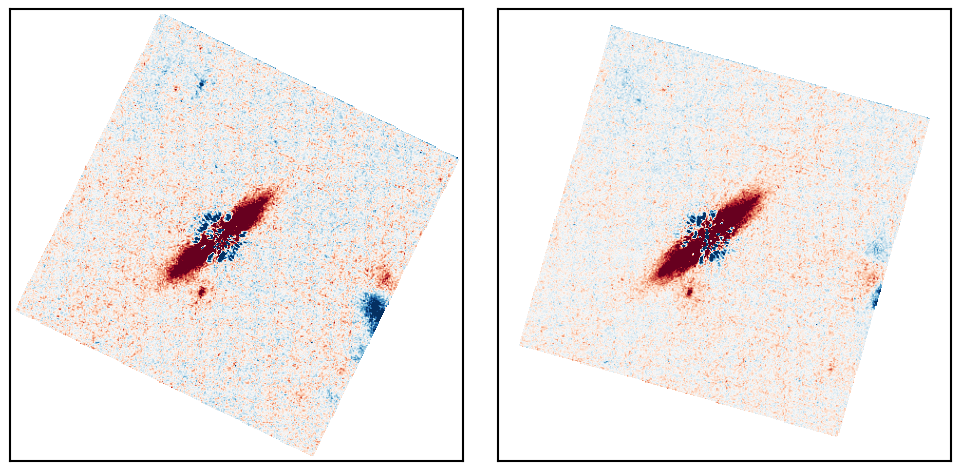

In [6]:
wdb.load_concat(0)

rdi_reduc = wdb.run_rdi()

quick_implot(rdi_reduc.rolls, clim_perc=98, cmap='RdBu_r')

At a glance, the first roll looks a lot noisier in the background-limited regime.

We can look at the err_rolls entries as well to see this more clearly:

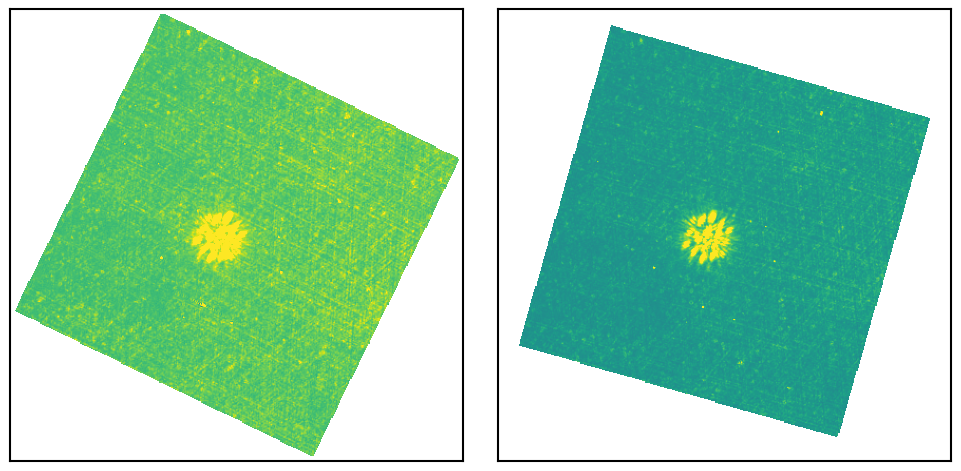

In [7]:
quick_implot(rdi_reduc.err_rolls, clim='0, 99%')

In [8]:
# Or, numerically, by computing the median pixel uncertainty for the region at least 100 pixels from the star in both rolls

mask = winnie.utils.dist_to_pt(wdb.c_star, wdb.nx, wdb.ny) > 100

np.nanmedian(rdi_reduc.err_rolls[..., mask], axis=-1).round(3)

array([1.751, 1.282])

What might cause this? Well, we wouldn't generally expect either input science image to have significantly higher initial BG noise levels (same exposure times). 

We can confirm this by inspecting "errcube_sci", which comes directly from the ERR extension of the input FITS file

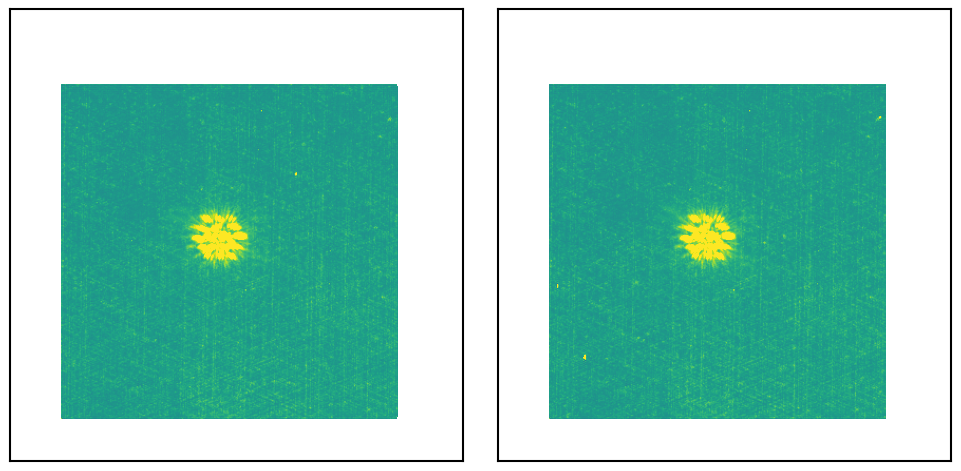

In [9]:
quick_implot(wdb.errcube_sci, clim='0, 99%')

In [10]:
# And numerically:
np.nanmedian(wdb.errcube_sci[..., mask], axis=-1).round(3)

array([0.268, 0.268])

Our PSF-subtracted uncertainty is simply

$
\sigma_{sub} = \sqrt{\sigma_{data}^2 + \sigma_{model}^2}
$

where $\sigma_{data}$ is the uncertainty from the 'ERR' FITS extension and $\sigma_{model}$ is the uncertainty for the stellar PSF model (which is propagated from the ERR extensions for the reference images).

(Note: this neglects residual speckle noise — so these maps should only be considered meaningful where residual speckle noise is small.)

Since $\sigma_{data}$ is not the cause, this means that the difference in noise is contributed by the stellar PSF model somehow.

Consider our PSF model uncertainty:

$
\sigma_{model} = \sqrt{(c_1\sigma_1)^2 + (c_2\sigma_2)^2 + ...} = \sqrt{\sum_i^N (c_i \sigma_i)^2}
$

for coefficients $c_i$ and reference image uncertainties $\sigma_i$.

Since our reference images all have the same exposure time, they should have comparable uncertainties in the background limited regime (assuming similar backgrounds). Let's verify this:

In [11]:
# Check the median pixel uncertainty for the same region as before in all 6 reference images

np.nanmedian(wdb.errcube_ref[..., mask], axis=-1).round(3)

array([0.098, 0.098, 0.098, 0.098, 0.099, 0.099])

For comparable reference image uncertainties ($\sigma_i = \sigma$), $\sigma_{model}$ becomes

$
\sigma_{model} \sim \sqrt{\sum_i^N (c_i \sigma)^2} = \sigma \sqrt{\sum_i^N c_i^2}
$


Thus our model variance is proportional to the sum of the squared coefficients:

$
\sigma_{model}^2 \propto \sum_i^N c_i^2 
$

From this, we could get a higher PSF-subtracted uncertainty for roll 1 if:

a) the coefficients are generally larger for roll 1 

b) one reference image dominates the model for roll 1, while roll 2 has more uniform coefficients


We can get a handle on this by looking at the actual RDI coefficients. 

We'll do this by having run_rdi pass the return_coeffs keyword to winnie.rdi.rdi_residuals (while also setting the return_res_only keyword for run_rdi, which tells it to directly return the result of rdi_residuals to us)

In [12]:
coeffs = wdb.run_rdi(return_res_only=True, return_coeffs=True)
coeffs.shape

(1, 2, 6, 1)

The axes here are (zones, science images, reference images, wavelengths).

Let's plot the squared values for the 6 coefficients for each of the two science rolls:

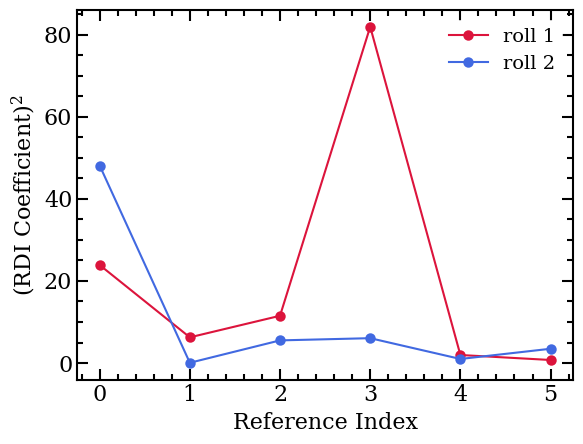

In [13]:
fig,ax = plt.subplots()

ax.plot(coeffs[0,0]**2, c='crimson', marker='o', label='roll 1')
ax.plot(coeffs[0,1]**2, c='royalblue', marker='o', label='roll 2')

lgd = ax.legend(edgecolor='None', fontsize=14)

ax.set(xlabel='Reference Index', ylabel='(RDI Coefficient)$^2$')

plt.show()

It looks like the cause is a little of both scenarios: roll 1's coefficients are generally larger (because of a larger coronagraph misalignment that is not repeated among the references) AND there's a large contribution from reference image 3.

This highlights a funny scenario that can emerge with similar data. If the coronagraph alignment of a particular science image is very well matched by one reference image, your stellar PSF model will likely be dominated by a single reference image. The alignment match will yield strong suppression of the stellar diffraction pattern and thus good sensitivity in the speckle-limited regime. However, the dominance of one reference image will result in a noisier stellar PSF model, thus potentially compromising the sensitivity in the background-limited regime. In other words, sensitivity at small separations can come at the price of sensitivity at larger separations. 

This is also a less-obvious way that using techniques like HPFRDI and MCRDI to mitigate oversubtraction can improve reductions.

In [14]:
# Run a quick HPFRDI procedure and grab the HPFRDI coefficients
wdb.load_concat(0)
wdb.hpfrdi_presets()

hpfrdi_reduc = wdb.run_rdi()

coeffs_hpfrdi = wdb.run_rdi(return_res_only=True, return_coeffs=True)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x154daf740>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


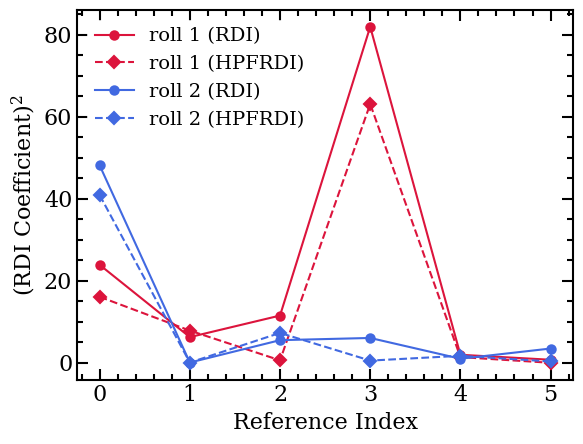

In [15]:
fig,ax = plt.subplots()

ax.plot(coeffs[0,0]**2, c='crimson', marker='o', label='roll 1 (RDI)')
ax.plot(coeffs_hpfrdi[0,0]**2, c='crimson', marker='D', ls='dashed', label='roll 1 (HPFRDI)')

ax.plot(coeffs[0,1]**2, c='royalblue', marker='o', label='roll 2 (RDI)')
ax.plot(coeffs_hpfrdi[0,1]**2, c='royalblue', marker='D', ls='dashed', label='roll 2 (HPFRDI)')

lgd = ax.legend(edgecolor='None', fontsize=14)

ax.set(xlabel='Reference Index', ylabel='(RDI Coefficient)$^2$')
plt.show()

In [16]:
# RDI background noise level
rdi_noise = np.nanmedian(rdi_reduc.err[mask])
print(rdi_noise.round(3))

1.015


In [17]:
# HPFRDI background noise level
hpfrdi_noise = np.nanmedian(hpfrdi_reduc.err[mask])
print(hpfrdi_noise.round(3))

0.881


In [18]:
print((hpfrdi_noise/rdi_noise).round(3))

0.868


Since RDI oversubtraction manifests as increased reference coefficients, this comes with additional noise in the eventual stellar PSF model.